<a href="https://colab.research.google.com/github/EronDS/Neural-Networks/blob/main/Autoencoder/Segmentation/Unet/NeuroImage/BrainMRISegmentationI/PyTorchUnet(ImageNet%2BInferenceNet-b0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloand and Dependencies

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39          10156       1409  0.9375           
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                        2MB  2022-05-15 00:01:23           2257         74  1.0              
mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 

## Downloading and Extracting (Unzip) dataset

In [2]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


# Code

In [1]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import pandas as pd
import keras
import matplotlib.pyplot as plt, seaborn as sns
import os
from PIL import Image
import cv2
import random
import numpy as np 
from sklearn.model_selection import train_test_split

import albumentations as A 
from torch.utils.data import DataLoader, Dataset
import torch

from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from tqdm import tqdm

device = 'cuda'

In [3]:
!unzip /content/lgg-mri-segmentation.zip

Archive:  /content/lgg-mri-segmentation.zip
replace kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: lgg-mri-segmentation/kaggle_3m/README.md  
  inflating: lgg-mri-segmentation/kaggle_3m/data.csv  


In [4]:
!mv /content/lgg-mri-segmentation/kaggle_3m/data.csv /content/data.csv && mv /content/lgg-mri-segmentation/kaggle_3m/README.md /content/README.md

In [5]:
df = pd.read_csv('/content/data.csv')
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [6]:
patients,imgs,masks = [],[],[]
data_folder = '/content/lgg-mri-segmentation/kaggle_3m'

In [7]:
for i in range(len(os.listdir(data_folder))):
  patient_id = '_'.join(os.listdir(data_folder)[i].split('_')[:3])
  patient_folder = os.listdir(data_folder)[i]
  for i in range(1,len(patient_folder)):
    img_file = patient_folder + '_' + str(i) + '.tif'
    mask_file = patient_folder + '_' + str(i) + '_mask.tif'
    patients.append(patient_folder),imgs.append(img_file),masks.append(mask_file)



In [8]:
df_ = pd.DataFrame({'patient_id':patients,
                    'imgs':imgs,
                    'masks':masks})

df_.head()

,patient_id,imgs,masks
0,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_1.tif,TCGA_HT_7692_19960724_1_mask.tif
1,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_2.tif,TCGA_HT_7692_19960724_2_mask.tif
2,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_3.tif,TCGA_HT_7692_19960724_3_mask.tif
3,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_4.tif,TCGA_HT_7692_19960724_4_mask.tif
4,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_5.tif,TCGA_HT_7692_19960724_5_mask.tif


## Labelling

In [9]:
df_.masks[1]

'TCGA_HT_7692_19960724_2_mask.tif'

In [10]:
folder = '/content/kaggle_3m/'
np.any(np.asarray(Image.open(folder+df_['patient_id'][1]+'/'+df_['masks'][1]))!=0)

False

In [11]:
lbls=[]
for i in range(len(df_)):
  if np.any(np.asarray(Image.open(folder+df_['patient_id'][i]+'/'+df_.masks[i]))!=0):lbls.append(1)
  else:lbls.append(0)

In [12]:
df_['labels'] = lbls

In [13]:
df_.head()

,patient_id,imgs,masks,labels
0,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_1.tif,TCGA_HT_7692_19960724_1_mask.tif,0
1,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_2.tif,TCGA_HT_7692_19960724_2_mask.tif,0
2,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_3.tif,TCGA_HT_7692_19960724_3_mask.tif,0
3,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_4.tif,TCGA_HT_7692_19960724_4_mask.tif,0
4,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_5.tif,TCGA_HT_7692_19960724_5_mask.tif,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '1: Tumor | 0: Healthy')

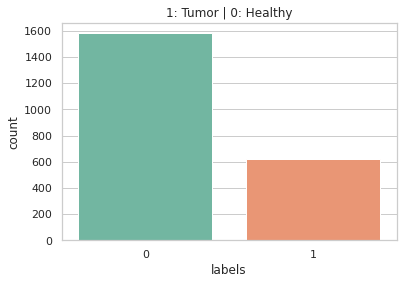

In [14]:
sns.set_theme(style='whitegrid',
              palette = 'Set2')
sns.countplot(df_.labels)
plt.title('1: Tumor | 0: Healthy')

## Visualization

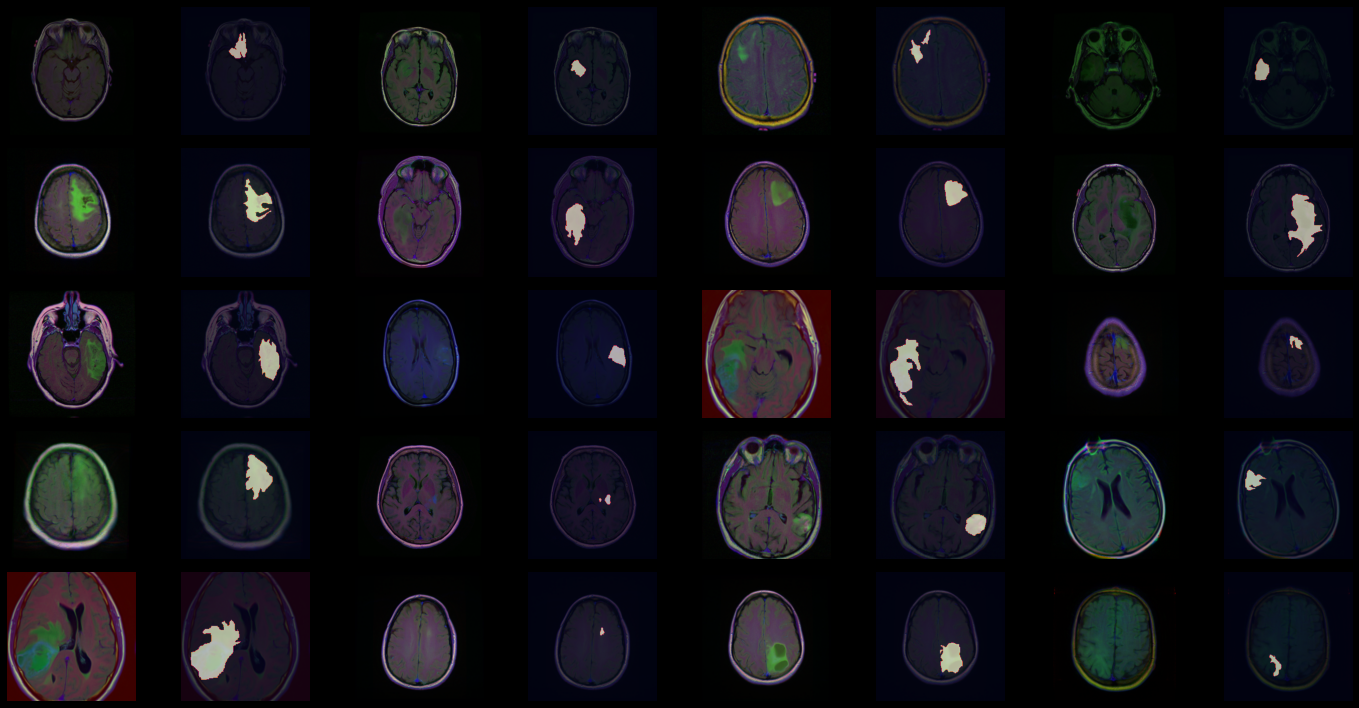

In [15]:

plt.style.use('dark_background')
plt.figure(figsize=(20,10))
for i in range(1,40,2):
  n = random.choice(list(df_[df_['labels'] == 1].index))
  plt.subplot(5,8,i)
  plt.imshow(Image.open(data_folder+'/'+'_'.join(imgs[n].split('.tif')[0].split('_')[:-1])+'/'+imgs[n]))
  plt.axis('off')
  plt.subplot(5,8,i+1)
  plt.imshow(Image.open(data_folder+'/'+'_'.join(imgs[n].split('.tif')[0].split('_')[:-1])+'/'+imgs[n]))
  plt.imshow(Image.open(data_folder+'/'+'_'.join(masks[n].split('.tif')[0].split('_')[:-2])+'/'+masks[n]), alpha=.65)
  plt.axis('off')
  plt.tight_layout()


In [16]:
df_.head()

,patient_id,imgs,masks,labels
0,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_1.tif,TCGA_HT_7692_19960724_1_mask.tif,0
1,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_2.tif,TCGA_HT_7692_19960724_2_mask.tif,0
2,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_3.tif,TCGA_HT_7692_19960724_3_mask.tif,0
3,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_4.tif,TCGA_HT_7692_19960724_4_mask.tif,0
4,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_5.tif,TCGA_HT_7692_19960724_5_mask.tif,0


##Augmentations

In [17]:
def train_augs():
  return A.Compose([
                    A.Resize(320,320),
                    A.HorizontalFlip(p=.5),
                    A.VerticalFlip(p=.5)
  ])

def val_augs():
  return A.Compose([A.Resize(320,320)])

##Preparing DataSet Function

In [18]:
class SegmentationDataset(Dataset): # inherit from Dataset model
  def __init__(self,df,augmentations):
    self.df= df
    self.augs = augmentations

  def __len__(self):return len(self.df)

  def __getitem__(self,ix):
    row = self.df.iloc[ix]
    img_path = data_folder+'/'+'_'.join(row.imgs.split('.tif')[0].split('_')[:-1])+'/'+row.imgs
    mask_path = data_folder+'/'+'_'.join(row.masks.split('.tif')[0].split('_')[:-2])+'/'+row.masks

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1) # adding channel dimension to grayscale img 

    if self.augs:
      data = self.augs(image = img, mask = mask) # return in dict form
      img = data['image']
      mask = data['mask']
    
    # tensor conversion  (h,w,c) -> (c,h,w) and normalization
    img = np.transpose(img, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    img = torch.Tensor(img) / 255.
    mask = torch.round(torch.Tensor(mask) / 255.) # round values between 0 and 1 to 0 and 1

    return img,mask



    

  

In [19]:
train_df,val_df = train_test_split(df_,test_size=.2)

In [20]:
trainset = SegmentationDataset(train_df, train_augs())
valset = SegmentationDataset(val_df,val_augs())

## DataLoader (specifying batch size)

In [21]:
train_dl = DataLoader(trainset, batch_size=8, shuffle=True)
val_dl = DataLoader(valset,batch_size=8)

In [22]:
print('Total no of Batches in Train: {}'.format(len(train_dl)))
print('Total no of Batches in Validation: {}'.format(len(val_dl)))

Total no of Batches in Train: 220
Total no of Batches in Validation: 55


In [23]:
for image,mask in train_dl:
  break

print('one Batch Shape:', (image.shape,mask.shape))

one Batch Shape: (torch.Size([8, 3, 320, 320]), torch.Size([8, 1, 320, 320]))


## Model (Unet with efficientnet-b0 encoder and imagenet weights)

In [24]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name = 'efficientnet-b0',
        encoder_weights = 'imagenet',
        in_channels = 3, # rgb input,
        classes = 1,
        activation=None 
        )
    
  def forward(self, images,masks = None):
    logits = self.arc(images)

    if mask != None:
      dice_loss = DiceLoss(mode = 'binary')(logits,masks)
      ce_loss = torch.nn.BCEWithLogitsLoss()(logits,masks)

      return logits, dice_loss+ce_loss
      
    return logits 




In [25]:
model = SegmentationModel()

In [26]:
model.to(device);

## Train and Evaluation Function

In [27]:
def train_fn(model,data_loader,optimizer):
  model.train() 
  total_loss = 0.0

  for imgs,masks in tqdm(data_loader):

    images = imgs.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()

    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step() # backprop

    total_loss += loss.item()

  
  return total_loss / len(data_loader) # total_loss / number of batches

def eval_fn(model,data_loader):
  model.eval()
  val_loss = 0

  with torch.no_grad():
    for imgs, masks in tqdm(data_loader):
      imgs = imgs.to(device)
      masks = masks.to(device)

      logits,loss = model(imgs,masks)
      val_loss += loss.item()

    return val_loss / len(data_loader)



In [28]:
opt = torch.optim.Adam(model.parameters(), 
                           lr = 3e-3, 
                           )


In [30]:
best_valid_loss = np.inf

train_losses, eval_losses = [], [] 

nb_epochs = 24
for i in range(nb_epochs):
  train_loss = train_fn(model,train_dl,opt)
  
  val_loss = eval_fn(model,val_dl)
  train_losses.append(train_loss)
  eval_losses.append(val_loss)

  if val_loss < best_valid_loss:
    best_valid_loss = val_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print('saved model!')

  
  print(f'Epoch:{i+1} | Train Loss : {train_loss} | Validation Loss: {val_loss}')


100%|██████████| 55/55 [00:06<00:00,  8.98it/s]


saved model!
Epoch:1 | Train Loss : 0.5150870160286021 | Validation Loss: 0.6233566280798352


100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch:2 | Train Loss : 0.3605810625550062 | Validation Loss: 0.7128069296479225


100%|██████████| 55/55 [00:04<00:00, 13.44it/s]


Epoch:3 | Train Loss : 0.3277774313841209 | Validation Loss: 24.339358884638006


100%|██████████| 55/55 [00:04<00:00, 12.80it/s]


saved model!
Epoch:4 | Train Loss : 0.30570848261903105 | Validation Loss: 0.376809974498511


100%|██████████| 55/55 [00:04<00:00, 13.40it/s]


saved model!
Epoch:5 | Train Loss : 0.2645598680637208 | Validation Loss: 0.2566165400311795


100%|██████████| 55/55 [00:04<00:00, 13.40it/s]


Epoch:6 | Train Loss : 0.2912531657947015 | Validation Loss: 0.2643713665697512


100%|██████████| 55/55 [00:04<00:00, 13.34it/s]


Epoch:7 | Train Loss : 0.2698148662924661 | Validation Loss: 0.35222331671481116


100%|██████████| 55/55 [00:04<00:00, 13.46it/s]


saved model!
Epoch:8 | Train Loss : 0.22110559974254845 | Validation Loss: 0.22725999305467584


100%|██████████| 55/55 [00:04<00:00, 13.33it/s]


Epoch:9 | Train Loss : 0.23530922729928533 | Validation Loss: 0.2526264880761036


100%|██████████| 55/55 [00:04<00:00, 13.44it/s]


Epoch:10 | Train Loss : 0.23119643400503223 | Validation Loss: 0.2508491916879641


100%|██████████| 55/55 [00:04<00:00, 13.24it/s]


Epoch:11 | Train Loss : 0.2834704487316427 | Validation Loss: 0.33368735761788976


100%|██████████| 55/55 [00:04<00:00, 13.42it/s]


Epoch:12 | Train Loss : 0.25224709940561796 | Validation Loss: 0.27428313012936667


100%|██████████| 55/55 [00:04<00:00, 13.47it/s]


Epoch:13 | Train Loss : 0.2674166918070362 | Validation Loss: 0.793609243712523


100%|██████████| 55/55 [00:04<00:00, 13.33it/s]


Epoch:14 | Train Loss : 0.26046440323677666 | Validation Loss: 0.6205078995975452


100%|██████████| 55/55 [00:04<00:00, 13.36it/s]


Epoch:15 | Train Loss : 0.24014477687333263 | Validation Loss: 0.29902544685100607


100%|██████████| 55/55 [00:04<00:00, 13.43it/s]


Epoch:16 | Train Loss : 0.25472209256756534 | Validation Loss: 0.30576004969494863


100%|██████████| 55/55 [00:04<00:00, 13.32it/s]


Epoch:17 | Train Loss : 0.2195228419029387 | Validation Loss: 0.2554784504988096


100%|██████████| 55/55 [00:04<00:00, 13.46it/s]


saved model!
Epoch:18 | Train Loss : 0.1991812645838081 | Validation Loss: 0.20365441001821719


100%|██████████| 55/55 [00:04<00:00, 13.38it/s]


Epoch:19 | Train Loss : 0.228024340162175 | Validation Loss: 0.40277271366033923


100%|██████████| 55/55 [00:04<00:00, 13.34it/s]


Epoch:20 | Train Loss : 0.2514245422326853 | Validation Loss: 0.2656211697552697


100%|██████████| 55/55 [00:04<00:00, 13.42it/s]


Epoch:21 | Train Loss : 0.21336841612854146 | Validation Loss: 0.20961526570602224


100%|██████████| 55/55 [00:04<00:00, 13.46it/s]


saved model!
Epoch:22 | Train Loss : 0.252626771578178 | Validation Loss: 0.1936917863648639


100%|██████████| 55/55 [00:04<00:00, 13.35it/s]


Epoch:23 | Train Loss : 0.1939727092891086 | Validation Loss: 0.20459509060767067


100%|██████████| 55/55 [00:04<00:00, 13.43it/s]

Epoch:24 | Train Loss : 0.2296551351993106 | Validation Loss: 0.27286778983021703


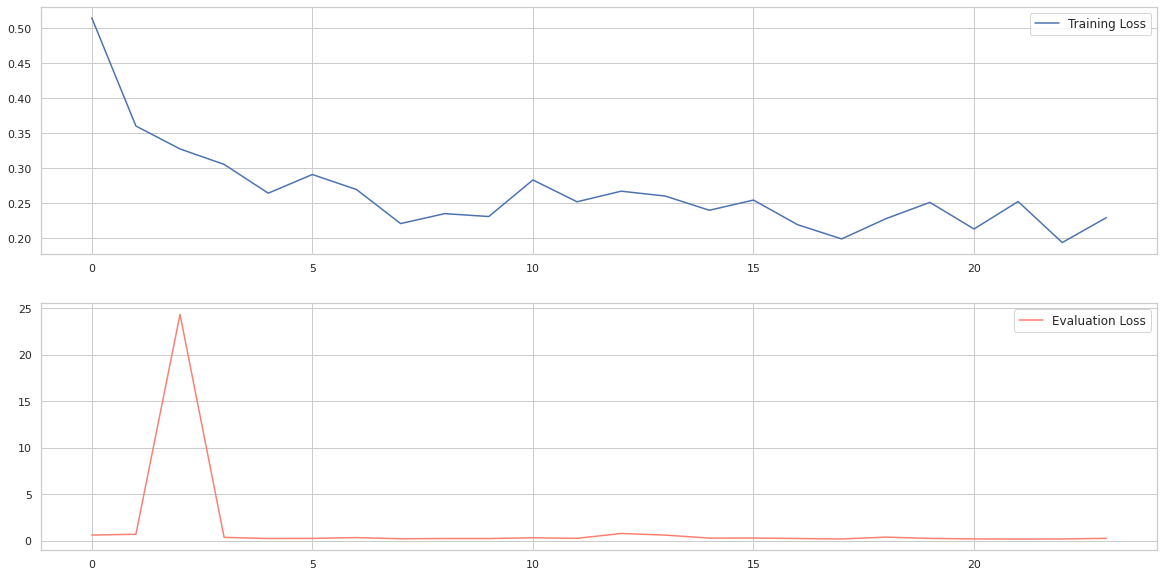

In [40]:
sns.set_theme(style= 'whitegrid')
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(train_losses, label = 'Training Loss')
plt.legend(fontsize=12)
plt.subplot(2,1,2)
plt.plot(eval_losses, label = 'Evaluation Loss')
plt.legend(fontsize=12)

In [71]:
print('Done!')

Done!
